In [6]:
'''---------------------------------------------
A brief version to test
---------------------------------------------'''

# import spectrum driver functions
from pyspcm import *
from spcm_tools import *
import matplotlib.pyplot as plt
import numpy as np
import time


szErrorTextBuffer = create_string_buffer(ERRORTEXTLEN)
dwError = uint32()
lStatus = int32()
lAvailUser = int32()
lPCPos = int32()
qwTotalMem = uint64(0)
qwToTransfer = uint64(KILO_B(2))

# settings for the FIFO mode buffer handling
# qwBufferSize = uint64(MEGA_B(1))
qwBufferSize = uint64(KILO_B(2))
lNotifySize = uint64(KILO_B(2))
# lNotifySize = uint64(MEGA_B(1))


# open card
# uncomment the second line and replace the IP address to use remote
# cards like in a digitizerNETBOX
hCard = spcm_hOpen(create_string_buffer(b'/dev/spcm0'))
# hCard = spcm_hOpen(create_string_buffer(b'TCPIP::192.168.1.10::inst0::INSTR'))
if not hCard:
    sys.stdout.write("no card found...\n")
    exit(1)
else:
    print('card found')


# do a simple standard setup
spcm_dwSetParam_i32(hCard, SPC_CHENABLE,       1)                      # just 1 channel enabled
spcm_dwSetParam_i32(hCard, SPC_PRETRIGGER,     1024)                   # 1k of pretrigger data at start of FIFO mode
spcm_dwSetParam_i32(hCard, SPC_CARDMODE,       SPC_REC_FIFO_MULTI)    # single FIFO mode
spcm_dwSetParam_i32(hCard, SPC_TIMEOUT,        5000)                   # timeout 5 s
spcm_dwSetParam_i32(hCard, SPC_TRIG_ORMASK,      SPC_TMASK_EXT0)       # external trigger
spcm_dwSetParam_i32(hCard, SPC_TRIG_EXT0_MODE,   SPC_TM_POS)           # trigger on positive edge
spcm_dwSetParam_i32(hCard, SPC_TRIG_EXT0_LEVEL0, 1500)                 # trigger at 1500mV
spcm_dwSetParam_i32(hCard, SPC_TRIG_ANDMASK,     0)                    # ...
spcm_dwSetParam_i32(hCard, SPC_CLOCKMODE,      SPC_CM_INTPLL)          # clock mode internal PLL


# we try to set the samplerate to 100 kHz (M2i) or 20 MHz on internal PLL, no clock output
spcm_dwSetParam_i64(hCard, SPC_SAMPLERATE, MEGA(20))
print('samplerate : 10M/s ')
spcm_dwSetParam_i32(hCard, SPC_CLOCKOUT, 0)                         # no clock output

# define the data buffer
# we try to use continuous memory if available and big enough
pvBuffer = ptr8()  # will be cast to correct type later
qwContBufLen = uint64(0)
spcm_dwGetContBuf_i64(hCard, SPCM_BUF_DATA, byref(pvBuffer), byref(qwContBufLen))
sys.stdout.write("ContBuf length: {0:d}\n".format(qwContBufLen.value))
pvBuffer = cast(pvAllocMemPageAligned(qwBufferSize.value), ptr8)  # cast to ptr8 to make it behave like the continuous memory
sys.stdout.write("Using buffer allocated by user program\n")


spcm_dwDefTransfer_i64(hCard, SPCM_BUF_DATA, SPCM_DIR_CARDTOPC, lNotifySize, pvBuffer, uint64(0), qwBufferSize)

# start everything
start_time = time.time()
dwError = spcm_dwSetParam_i32(hCard, SPC_M2CMD, M2CMD_CARD_START | M2CMD_CARD_ENABLETRIGGER | M2CMD_DATA_STARTDMA)


# check for error
if dwError != 0:  # != ERR_OK
    spcm_dwGetErrorInfo_i32(hCard, None, None, szErrorTextBuffer)
    sys.stdout.write("{0}\n".format(szErrorTextBuffer.value))
    spcm_vClose(hCard)
    exit(1)

# run the FIFO mode and loop through the data
else:
    lMin = int(32767)   # normal python type
    lMax = int(-32768)  # normal python type
    temp = []
    loop = 0
    while loop != 10:
        qwTotalMem = uint64(0)
        loop += 1
        while qwTotalMem.value < qwToTransfer.value:
            dwError = spcm_dwSetParam_i32(hCard, SPC_M2CMD, M2CMD_DATA_WAITDMA)
            if dwError != ERR_OK:
                if dwError == ERR_TIMEOUT:
                    sys.stdout.write("... Timeout\n")
                    break
                else:
                    sys.stdout.write("... Error: {0:d}\n".format(dwError))
                    break

            else:
                spcm_dwGetParam_i32(hCard, SPC_M2STATUS,            byref(lStatus))
                spcm_dwGetParam_i32(hCard, SPC_DATA_AVAIL_USER_LEN, byref(lAvailUser))
                spcm_dwGetParam_i32(hCard, SPC_DATA_AVAIL_USER_POS, byref(lPCPos))

                if lAvailUser.value >= lNotifySize.value:
                    qwTotalMem.value += lNotifySize.value
                    sys.stdout.write("Stat:{0:08x} Pos:{1:08x} Avail:{2:08x} Total:{3:.2f}MB/{4:.2f}MB\n".format(lStatus.value, lPCPos.value, lAvailUser.value, c_double(qwTotalMem.value).value / MEGA_B(1), c_double(qwToTransfer.value).value / MEGA_B(1)))

                    # this is the point to do anything with the data
                    # e.g. calculate minimum and maximum of the acquired data
                    pnData = cast(addressof(pvBuffer.contents) + lPCPos.value, ptr16)  # cast to pointer to 16bit integer
                    
                    lNumSamples = int(lNotifySize.value / 2)  # two bytes per sample
                    for i in range(0, lNumSamples - 1, 1):
                        temp.append(pnData[i])
                        if pnData[i] < lMin:
                            lMin = pnData[i]
                        if pnData[i] > lMax:
                            lMax = pnData[i]

                    spcm_dwSetParam_i32(hCard, SPC_DATA_AVAIL_CARD_LEN,  lNotifySize)

# send the stop command
end_time = time.time()
dwError = spcm_dwSetParam_i32(hCard, SPC_M2CMD, M2CMD_CARD_STOP | M2CMD_DATA_STOPDMA)

sys.stdout.write("Finished...\n")
sys.stdout.write("Minimum: {0:d}\n".format(lMin))
sys.stdout.write("Maximum: {0:d}\n".format(lMax))

# clean up
spcm_vClose(hCard)

# plot the data
print('number of samples: ', len(temp))
print('time cost: ', end_time - start_time, 's')
plt.plot(temp)
plt.show()

card found
samplerate : 10M/s 
ContBuf length: 0
Using buffer allocated by user program
... Timeout
... Timeout
... Timeout
... Timeout


KeyboardInterrupt: 

Found: M4i.4421-x8 sn 20846
ContBuf length: 0
Using buffer allocated by user program

  !!! Using external trigger - please connect a signal to the trigger input !!!

Segment[1] : Minimum: -16243, Maximum: -3572
Segment[2] : Minimum: -16240, Maximum: -3563
Segment[3] : Minimum: -16256, Maximum: -3579
Segment[4] : Minimum: -16242, Maximum: -3580
Segment[5] : Minimum: -16256, Maximum: -3558
Segment[6] : Minimum: -16245, Maximum: -3576
Segment[7] : Minimum: -16240, Maximum: -3572
Segment[8] : Minimum: -16259, Maximum: -3584
Segment[9] : Minimum: -16241, Maximum: -3561
Segment[10] : Minimum: -16241, Maximum: -3570
Segment[11] : Minimum: -16238, Maximum: -3565
Segment[12] : Minimum: -16245, Maximum: -3570
Segment[13] : Minimum: -16251, Maximum: -3582
Segment[14] : Minimum: -16239, Maximum: -3566
Segment[15] : Minimum: -16245, Maximum: -3582
Segment[16] : Minimum: -16241, Maximum: -3573
Segment[17] : Minimum: -16238, Maximum: -3571
Segment[18] : Minimum: -16249, Maximum: -3563
Segment[19] : 

In [1]:
dwError = spcm_dwSetParam_i32(hCard, SPC_M2CMD, M2CMD_CARD_STOP | M2CMD_DATA_STOPDMA)

NameError: name 'spcm_dwSetParam_i32' is not defined

In [32]:
#
# **************************************************************************
#
# simple_rec_fifo_multi_ts_poll.py                         (c) Spectrum GmbH
#
# **************************************************************************
#
# Example for all SpcmDrv digital acquisition cards. 
# Shows a simple standard mode example using only the few necessary commands
#
# Information about the different products and their drivers can be found
# online in the Knowledge Base:
# https://www.spectrum-instrumentation.com/en/platform-driver-and-series-differences
#
# Feel free to use this source for own projects and modify it in any way
#
# Documentation for the API as well as a detailed description of the hardware
# can be found in the manual for each device which can be found on our website:
# https://www.spectrum-instrumentation.com/en/downloads
#
# Further information can be found online in the Knowledge Base:
# https://www.spectrum-instrumentation.com/en/knowledge-base-overview
#
# **************************************************************************
#

# import spectrum driver functions
from pyspcm import *
from spcm_tools import *

#
# **************************************************************************
# main
# **************************************************************************
#

szErrorTextBuffer = create_string_buffer(ERRORTEXTLEN)
dwError = uint32()
lStatus = int32()
lAvailUser = int32()
lPCPos = int32()
lChCount = int32()
qwTotalMem = uint64(0)
qwToTransfer = uint64(MEGA_B(8))
lSegmentIndex = uint32(0)
lSegmentCnt = uint32(0)
llSamplingrate = int64(0)

# settings for the FIFO mode buffer handling
qwBufferSize = uint64(MEGA_B(4))
lNotifySize = int32(KILO_B(8))

# open card
# uncomment the second line and replace the IP address to use remote
# cards like in a digitizerNETBOX
hCard = spcm_hOpen(create_string_buffer(b'/dev/spcm0'))
# hCard = spcm_hOpen(create_string_buffer(b'TCPIP::192.168.1.10::inst0::INSTR'))
if not hCard:
    sys.stdout.write("no card found...\n")
    exit(1)

# read type, function and sn and check for A/D card
lCardType = int32(0)
spcm_dwGetParam_i32(hCard, SPC_PCITYP, byref(lCardType))
lSerialNumber = int32(0)
spcm_dwGetParam_i32(hCard, SPC_PCISERIALNO, byref(lSerialNumber))
lFncType = int32(0)
spcm_dwGetParam_i32(hCard, SPC_FNCTYPE, byref(lFncType))
lFeatureMap = int32(0)
spcm_dwGetParam_i32(hCard, SPC_PCIFEATURES, byref(lFeatureMap))

sCardName = szTypeToName(lCardType.value)
if lFncType.value == SPCM_TYPE_AI:
    sys.stdout.write("Found: {0} sn {1:05d}\n".format(sCardName, lSerialNumber.value))
else:
    sys.stdout.write("This is an example for A/D cards.\nCard: {0} sn {1:05d} not supported by example\n".format(sCardName, lSerialNumber.value))
    spcm_vClose(hCard)
    exit(1)

if lFeatureMap.value & SPCM_FEAT_MULTI == 0:
    sys.stdout.write("Multiple Recording Option not installed !\n")
    spcm_vClose(hCard)
    exit(1)

if lFeatureMap.value & SPCM_FEAT_TIMESTAMP == 0:
    sys.stdout.write("Timestamp Option not installed !\n")
    spcm_vClose(hCard)
    exit(1)

lSegmentSize = 4096

# do a simple standard setup
spcm_dwSetParam_i32(hCard, SPC_CHENABLE,         1)                      # just 1 channel enabled
spcm_dwSetParam_i32(hCard, SPC_PRETRIGGER,       1024)                   # 1k of pretrigger data at start of FIFO mode
spcm_dwSetParam_i32(hCard, SPC_CARDMODE,         SPC_REC_FIFO_MULTI)     # multiple recording FIFO mode
spcm_dwSetParam_i32(hCard, SPC_SEGMENTSIZE,      lSegmentSize)           # set segment size
spcm_dwSetParam_i32(hCard, SPC_POSTTRIGGER,      lSegmentSize - 128)     # set posttrigger
spcm_dwSetParam_i32(hCard, SPC_LOOPS,            0)                      # set loops
spcm_dwSetParam_i32(hCard, SPC_CLOCKMODE,        SPC_CM_INTPLL)          # clock mode internal PLL
spcm_dwSetParam_i32(hCard, SPC_CLOCKOUT,         0)                      # no clock output
spcm_dwSetParam_i32(hCard, SPC_TRIG_EXT0_MODE,   SPC_TM_POS)             # set trigger mode
spcm_dwSetParam_i32(hCard, SPC_TRIG_TERM,        0)                      # set trigger termination
spcm_dwSetParam_i32(hCard, SPC_TRIG_ORMASK,      SPC_TMASK_EXT0)         # trigger set to external
spcm_dwSetParam_i32(hCard, SPC_TRIG_ANDMASK,     0)                      # ...
spcm_dwSetParam_i32(hCard, SPC_TRIG_EXT0_ACDC,   COUPLING_DC)            # trigger coupling
spcm_dwSetParam_i32(hCard, SPC_TRIG_EXT0_LEVEL0, 1500)                   # trigger level of 1.5 Volt
spcm_dwSetParam_i32(hCard, SPC_TRIG_EXT0_LEVEL1, 0)                      # unused
spcm_dwSetParam_i32(hCard, SPC_TIMEOUT,          5000)                   # timeout 5 s

spcm_dwGetParam_i32(hCard, SPC_CHCOUNT, byref(lChCount))
for lChannel in range(0, lChCount.value, 1):
    spcm_dwSetParam_i32(hCard, SPC_AMP0 + lChannel * (SPC_AMP1 - SPC_AMP0), 1000)

# we try to set the samplerate to 100 kHz (M2i) or 20 MHz on internal PLL, no clock output
spcm_dwSetParam_i64(hCard, SPC_SAMPLERATE, int64(MEGA(20)))
print('samplerate : 20MHz ')

# read back current sampling rate from driver
spcm_dwGetParam_i64(hCard, SPC_SAMPLERATE, byref(llSamplingrate))


# define the data buffer
# we try to use continuous memory if available and big enough
pvBuffer = ptr8()  # will be cast to correct type later
qwContBufLen = uint64(0)
spcm_dwGetContBuf_i64(hCard, SPCM_BUF_DATA, byref(pvBuffer), byref(qwContBufLen))
sys.stdout.write("ContBuf length: {0:d}\n".format(qwContBufLen.value))
if qwContBufLen.value >= qwBufferSize.value:
    sys.stdout.write("Using continuous buffer\n")
else:
    pvBuffer = cast(pvAllocMemPageAligned(qwBufferSize.value), ptr8)  # cast to ptr8 to make it behave like the continuous memory
    sys.stdout.write("Using buffer allocated by user program\n")

sys.stdout.write("\n  !!! Using external trigger - please connect a signal to the trigger input !!!\n\n")

# set up buffer for data transfer
spcm_dwDefTransfer_i64(hCard, SPCM_BUF_DATA, SPCM_DIR_CARDTOPC, lNotifySize, pvBuffer, uint64(0), qwBufferSize)

# start everything
dwError = spcm_dwSetParam_i32(hCard, SPC_M2CMD, M2CMD_CARD_START | M2CMD_CARD_ENABLETRIGGER | M2CMD_DATA_STARTDMA)

# check for error
if dwError != 0:  # != ERR_OK
    spcm_dwGetErrorInfo_i32(hCard, None, None, szErrorTextBuffer)
    sys.stdout.write("{0}\n".format(szErrorTextBuffer.value))
    spcm_vClose(hCard)
    exit(1)

# run the FIFO mode and loop through the data
else:
    lMin = int(32767)  # normal python type
    lMax = int(-32768)  # normal python type
    
    while qwTotalMem.value < qwToTransfer.value:
        temp = list()
        dwError = spcm_dwSetParam_i32(hCard, SPC_M2CMD, M2CMD_DATA_WAITDMA)
        if dwError != ERR_OK:
            if dwError == ERR_TIMEOUT:
                sys.stdout.write("... Timeout\n")
            else:
                sys.stdout.write("... Error: {0:d}\n".format(dwError))
                break

        else:
            spcm_dwGetParam_i32(hCard, SPC_M2STATUS,            byref(lStatus))
            spcm_dwGetParam_i32(hCard, SPC_DATA_AVAIL_USER_LEN, byref(lAvailUser))
            spcm_dwGetParam_i32(hCard, SPC_DATA_AVAIL_USER_POS, byref(lPCPos))

            if lAvailUser.value >= lNotifySize.value:
                qwTotalMem.value += lNotifySize.value

                # this is the point to do anything with the data
                # e.g. calculate minimum and maximum of the acquired data
                pnData = cast(addressof(pvBuffer.contents) + lPCPos.value, ptr16)  # cast to pointer to 16bit integer
                lNumSamples = int(lNotifySize.value / 2)  # two bytes per sample
                for i in range(0, lNumSamples - 1, 1):
                    temp.append(pnData[i])
                    if pnData[i] < lMin:
                        lMin = pnData[i]
                    if pnData[i] > lMax:
                        lMax = pnData[i]

                    lSegmentIndex.value += 1
                    lSegmentIndex.value %= lSegmentSize

                    # check end of acquired segment
                    if lSegmentIndex.value == 0:
                        lSegmentCnt.value += 1

                        sys.stdout.write("Segment[{0:d}] : Minimum: {1:d}, Maximum: {2:d}\n".format(lSegmentCnt.value, lMin, lMax))

                        lMin = 32767
                        lMax = -32768

                spcm_dwSetParam_i32(hCard, SPC_DATA_AVAIL_CARD_LEN, lNotifySize)

# send stop command
dwError = spcm_dwSetParam_i32(hCard, SPC_M2CMD, M2CMD_CARD_STOP | M2CMD_DATA_STOPDMA)

sys.stdout.write("Finished...\n")

# clean up
spcm_vClose(hCard)


Found: M4i.4421-x8 sn 20846
samplerate : 20MHz 
ContBuf length: 0
Using buffer allocated by user program

  !!! Using external trigger - please connect a signal to the trigger input !!!

Segment[1] : Minimum: -13, Maximum: 23
Segment[2] : Minimum: -16, Maximum: 24
Segment[3] : Minimum: -15, Maximum: 24
Segment[4] : Minimum: -11, Maximum: 25
Segment[5] : Minimum: -9, Maximum: 23
Segment[6] : Minimum: -10, Maximum: 24
Segment[7] : Minimum: -12, Maximum: 24
Segment[8] : Minimum: -11, Maximum: 21
Segment[9] : Minimum: -12, Maximum: 26
Segment[10] : Minimum: -10, Maximum: 25
Segment[11] : Minimum: -12, Maximum: 22
Segment[12] : Minimum: -12, Maximum: 27
Segment[13] : Minimum: -15, Maximum: 23
Segment[14] : Minimum: -11, Maximum: 24
Segment[15] : Minimum: -14, Maximum: 22
Segment[16] : Minimum: -12, Maximum: 23
Segment[17] : Minimum: -12, Maximum: 26
Segment[18] : Minimum: -11, Maximum: 21
Segment[19] : Minimum: -12, Maximum: 24
Segment[20] : Minimum: -10, Maximum: 25
Segment[21] : Minimum: 

number of samples: 4095 *  1.0


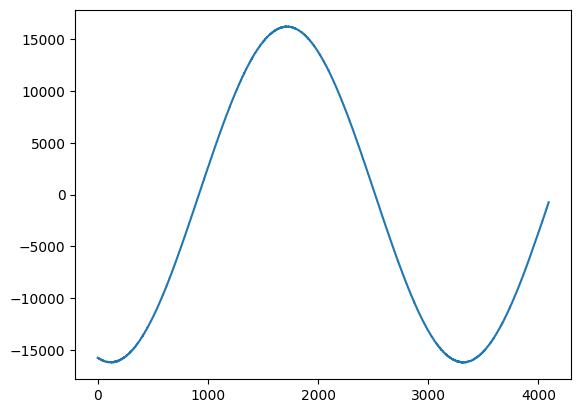

In [30]:
print('number of samples: 4095 * ', len(temp)/4095)
import matplotlib.pyplot as plt
plt.plot(temp)

In [ ]:
def on_activate(self):

def on_deactivate(self):

def get_constraints(self):

def configure(self, bin_width_s, record_length_s, number_of_gates = 0):

def get_status(self):

def start_measure(self):
    pipe1: sender(data)
def pause_measure(self):

def stop_measure(self):

def continue_measure(self):

def is_gated(self):

def get_binwidth(self):

def get_data_trace(self):
    pipe2: receiver(data)/sender(signal)
def prallel_averager(self):
    pipe1: receiver(data)
    pipe2: sender(data)/receiver(signal)